### CHECK KAGGLE TOKEN & LOAD DATASET

In [7]:
import os
import zipfile

# Function to download dataset
def download_dataset(dataset_name, zip_file_path):
    os.system(f'kaggle datasets download -d {dataset_name} -p {os.path.dirname(zip_file_path)}')
    if not os.path.exists(zip_file_path):
        raise FileNotFoundError(f"Dataset '{zip_file_path}' not found after download.")
    return zip_file_path

# Attempt to extract ZIP file
def extract_zip(file_path, extract_to):
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Dataset extracted successfully.")
    except zipfile.BadZipFile:
        print(f"Bad ZIP file: {file_path}. Re-downloading...")
        os.remove(file_path)
        download_dataset(dataset_name, file_path)
        extract_zip(file_path, extract_to)

# Resolve base directory for Jupyter Notebook
# Use the current working directory and navigate up to set the base directory
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Set dataset details using paths relative to the base directory
dataset_name = 'nelgiriyewithana/global-weather-repository'
zip_file_name = os.path.join(base_dir, 'data', 'raw', 'global-weather-repository.zip')
extract_dir = os.path.join(base_dir, 'data', 'raw')

# Ensure the `data/raw` directory exists
os.makedirs(os.path.dirname(zip_file_name), exist_ok=True)

# Ensure Kaggle credentials
kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError("Kaggle API credentials not found. Place 'kaggle.json' in ~/.kaggle.")

os.chmod(kaggle_json_path, 0o600)

# Download and extract
download_dataset(dataset_name, zip_file_name)
extract_zip(zip_file_name, extract_dir)


Dataset extracted successfully.


### DATA PREPARATION

In [11]:
import os
import pandas as pd

# Load the dataset (update the file path if necessary)
file_path = '../data/raw/GlobalWeatherRepository.csv'
data = pd.read_csv(file_path)

# Filter for rows where country is "Thailand" and location_name is "Bangkok"
filtered_data = data[(data['country'] == 'Thailand') & (data['location_name'] == 'Bangkok')]

# Select only the required columns
filtered_data = filtered_data[['air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_Carbon_Monoxide', 'air_quality_PM2.5', 'temperature_celsius', 'humidity']]

# Define the output file path
output_file_path = '../data/processed/filtered_data_thailand_bangkok.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Save the filtered data to a new CSV file
filtered_data.to_csv(output_file_path, index=False)

print("Filtered data saved to", output_file_path)


Filtered data saved to ../data/processed/filtered_data_thailand_bangkok.csv


### ARIMA

Preparing data...

Training ARIMA model...

Model Performance Metrics:
Mean Squared Error: 4030.09
Root Mean Squared Error: 63.48
Mean Absolute Error: 59.34
R² Score: -1.99

Next Day Prediction:
Predicted PM2.5 value for next day: 101.81

Plotting results...


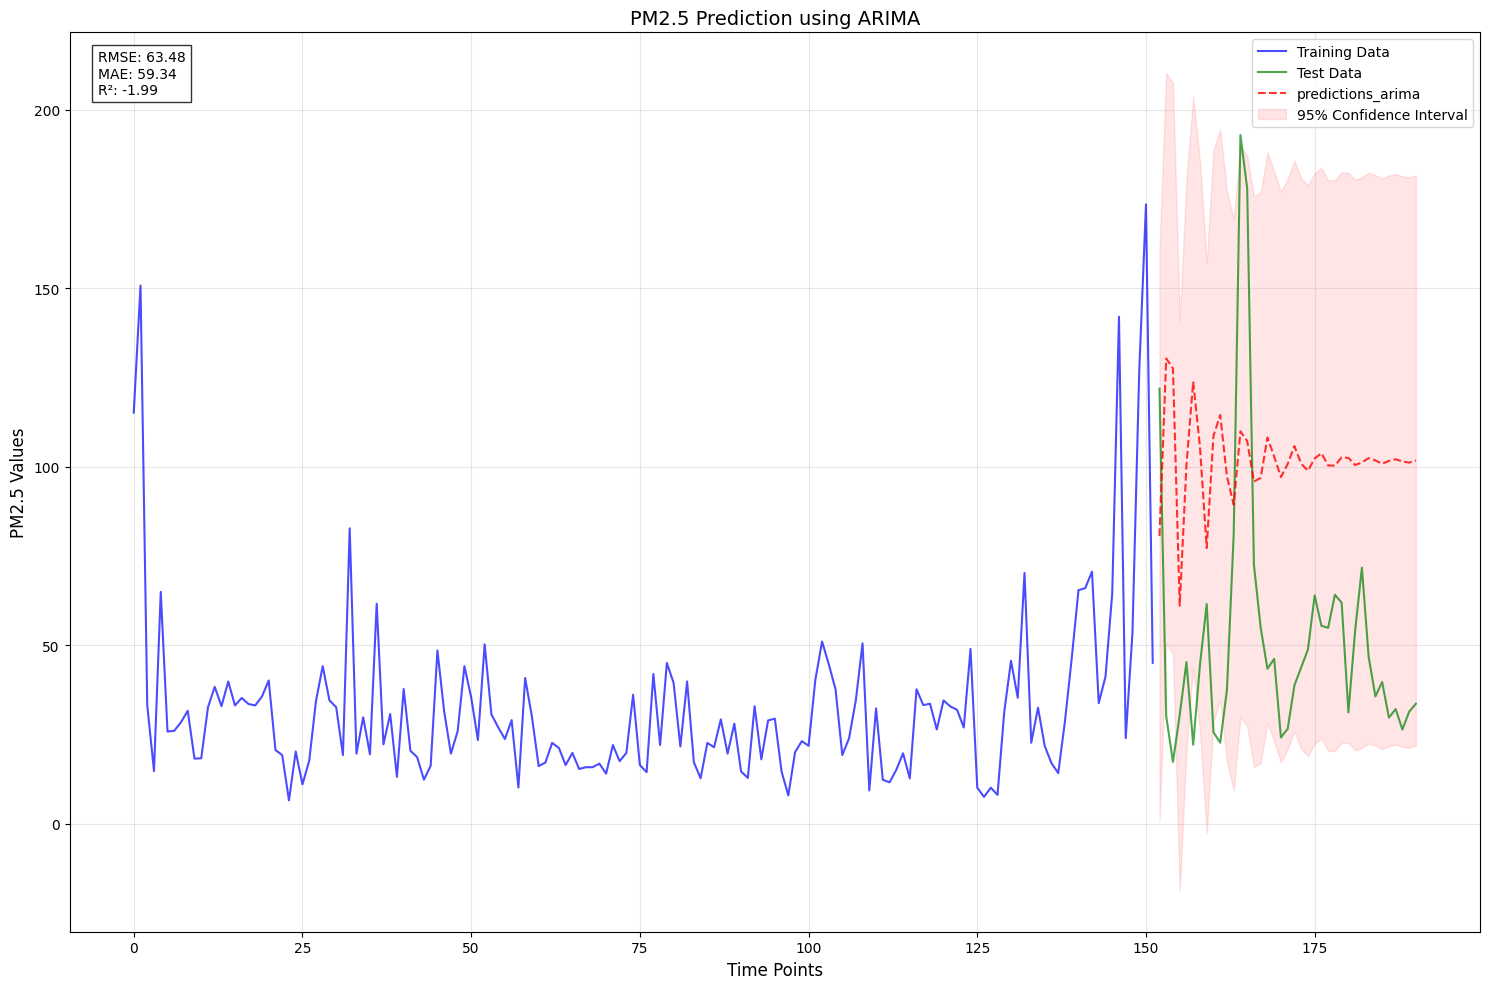

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:      air_quality_PM2.5   No. Observations:                  152
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -669.737
Date:                Tue, 26 Nov 2024   AIC                           1351.475
Time:                        14:32:56   BIC                           1369.579
Sample:                             0   HQIC                          1358.830
                                - 152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6000      0.057    -10.561      0.000      -0.711      -0.489
ar.L2         -0.6174      0.076     -8.144      0.000      -0.766      -0.469
ar.L3         -0.3709      0.08

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Read the CSV file
data = pd.read_csv('../data/processed/filtered_data_thailand_bangkok.csv')

# Create features for time series forecasting
def create_features(df):
    """Create time series features for the ARIMA model"""
    df_features = pd.DataFrame()
    
    # Use the target variable (air_quality_PM2.5) for time series prediction
    df_features['PM2.5'] = df['air_quality_PM2.5']
    
    return df_features

def prepare_data(df, target_col='air_quality_PM2.5'):
    """Prepare data for ARIMA model"""
    # Create features
    features = create_features(df)
    target = df[target_col]
    
    # Remove rows with NaN values (created by lag/rolling features)
    features = features.dropna()
    target = target[features.index]
    
    # Split the data (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test

def train_arima(y_train, y_test):
    """Train ARIMA model and make predictions"""
    # Fit ARIMA model
    arima_model = ARIMA(y_train, order=(5, 1, 0))  # Example ARIMA(5,1,0) model
    arima_model_fit = arima_model.fit()
    
    # Make predictions
    predictions_arima = arima_model_fit.forecast(steps=len(y_test))
    
    return predictions_arima, arima_model_fit

def plot_results(y_train, y_test, predictions_arima):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot test data and predictions_arima
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Test Data', color='green', alpha=0.7)
    plt.plot(test_range, predictions_arima, 
             label='predictions_arima', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals using prediction std
    residuals = y_test - predictions_arima
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions_arima - 2*std_dev,
                     predictions_arima + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('PM2.5 Prediction using ARIMA', fontsize=14)
    plt.xlabel('Time Points', fontsize=12)
    plt.ylabel('PM2.5 Values', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions_arima)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions_arima):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions_arima):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(arima_model_fit):
    """Plot feature importance for ARIMA model (optional)"""
    # ARIMA does not have explicit feature importance like tree-based models,
    # but we can plot residuals or coefficients if needed
    print("ARIMA Model Summary:")
    print(arima_model_fit.summary())

# Prepare the data
print("Preparing data...")
X_train, X_test, y_train, y_test = prepare_data(data)

# Train model and make predictions_arima
print("\nTraining ARIMA model...")
predictions_arima, arima_model_fit = train_arima(y_train, y_test)

# Calculate metrics
mse_arima = mean_squared_error(y_test, predictions_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_test, predictions_arima)
r2_arima = r2_score(y_test, predictions_arima)

# Print results
print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse_arima:.2f}")
print(f"Root Mean Squared Error: {rmse_arima:.2f}")
print(f"Mean Absolute Error: {mae_arima:.2f}")
print(f"R² Score: {r2_arima:.2f}")

# Make next day prediction
print("\nNext Day Prediction:")

# If predictions_arima are a pandas Series or numpy array, access the last element
next_day_prediction = predictions_arima[-1] if isinstance(predictions_arima, np.ndarray) else predictions_arima.iloc[-1]
print(f"Predicted PM2.5 value for next day: {next_day_prediction:.2f}")

# Visualize results
print("\nPlotting results...")
plot_results(y_train, y_test, predictions_arima)

# Optional: Print the ARIMA model summary
plot_feature_importance(arima_model_fit)


### XGBoost



Training XGBoost model...

Model Performance Metrics:
Mean Squared Error: 214.36
Root Mean Squared Error: 14.64
Mean Absolute Error: 11.27
R² Score: 0.83

Next Day Prediction:
Predicted PM2.5 value for next day: 23.93

Plotting results...


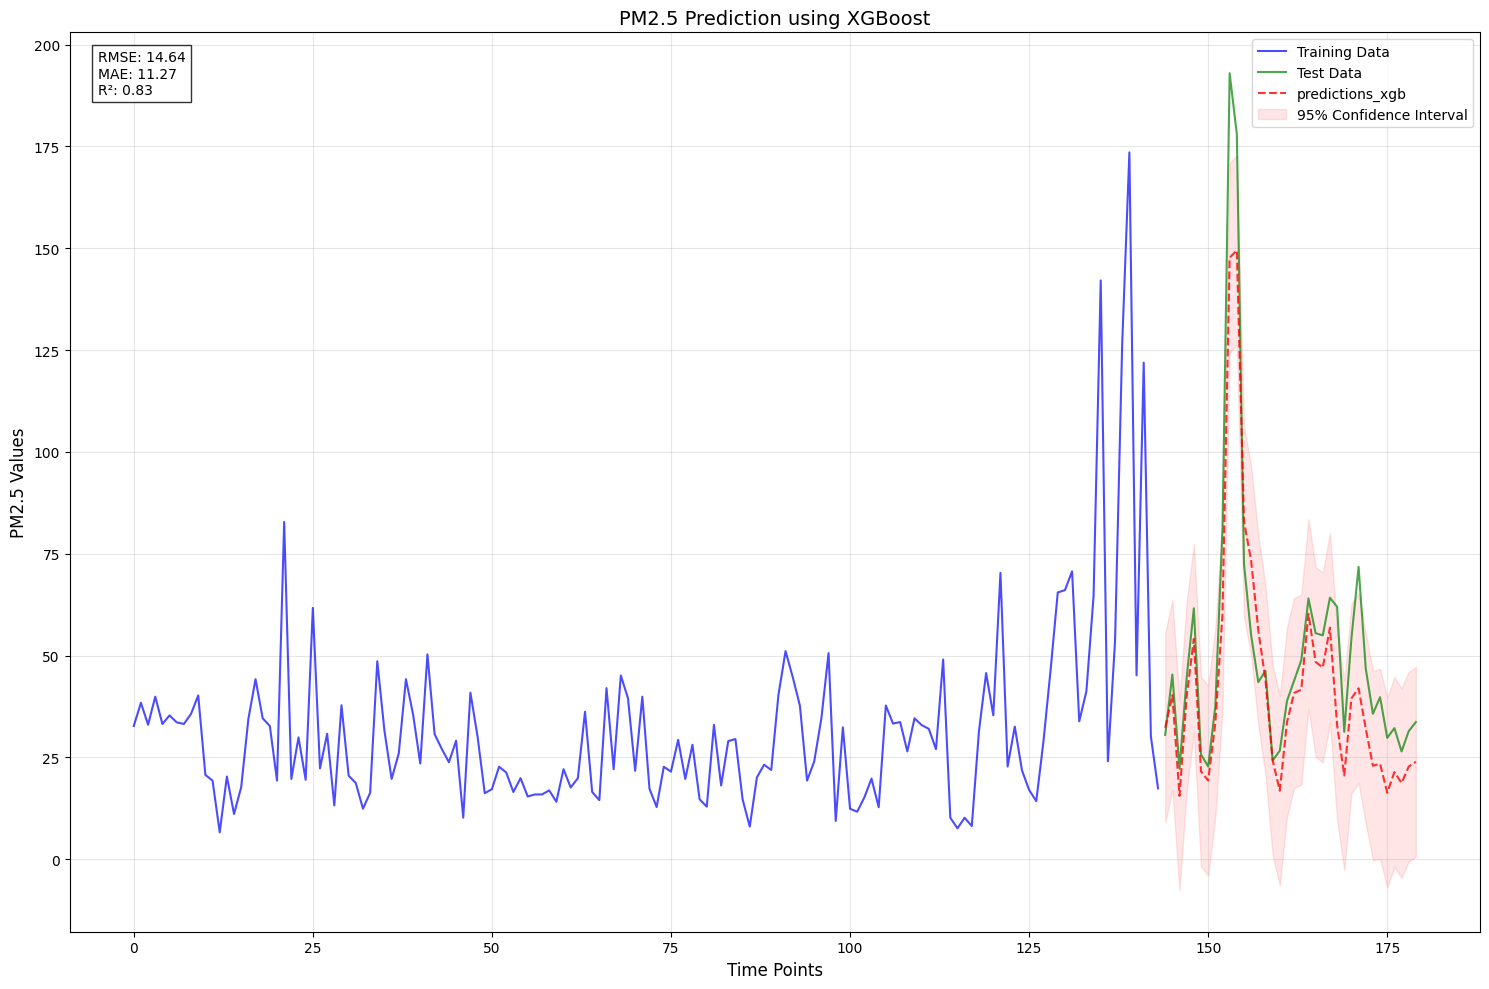

<class 'pandas.core.frame.DataFrame'>


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load pre-split data from CSV files
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

def train_xgboost(X_train, y_train, X_test):
    """Train XGBoost model and make predictions_xgb"""
    # Initialize and train the model
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        min_child_weight=5,
        learning_rate=0.1,
        random_state=42
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Make predictions_xgb
    predictions_xgb = xgb_model.predict(X_test)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return predictions_xgb, feature_importance

def plot_results(y_train, y_test, predictions_xgb):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Flatten y_test in case it's a DataFrame or Series with extra dimensions
    y_test = y_test.values.flatten() if isinstance(y_test, pd.DataFrame) else y_test
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot test data and predictions_xgb
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Test Data', color='green', alpha=0.7)
    plt.plot(test_range, predictions_xgb, 
             label='predictions_xgb', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals using prediction std
    residuals = y_test - predictions_xgb
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions_xgb - 2*std_dev,
                     predictions_xgb + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('PM2.5 Prediction using XGBoost', fontsize=14)
    plt.xlabel('Time Points', fontsize=12)
    plt.ylabel('PM2.5 Values', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions_xgb)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions_xgb):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions_xgb):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()


def plot_feature_importance(feature_importance):
    """Plot feature importance"""
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['feature'][:10], 
             feature_importance['importance'][:10])
    plt.title('Top 10 Most Important Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Train model and make predictions_xgb
print("\nTraining XGBoost model...")
predictions_xgb, feature_importance = train_xgboost(X_train, y_train, X_test)

# Calculate metrics
mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)

# Print results
print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse_xgb:.2f}")
print(f"Root Mean Squared Error: {rmse_xgb:.2f}")
print(f"Mean Absolute Error: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

# Make next day prediction
print("\nNext Day Prediction:")
next_day_prediction = predictions_xgb[-1]  # Predicting for the last test sample
print(f"Predicted PM2.5 value for next day: {next_day_prediction:.2f}")

# Visualize results
print("\nPlotting results...")
plot_results(y_train, y_test, predictions_xgb)
print(type(y_test))


### Random Forest 


Preparing data...

Training Random Forest model...

Model Performance Metrics:
Mean Squared Error: 260.07
Root Mean Squared Error: 16.13
Mean Absolute Error: 9.84
R² Score: 0.80

Next Day Prediction:
Predicted PM2.5 value for next day: 21.37

Plotting results...


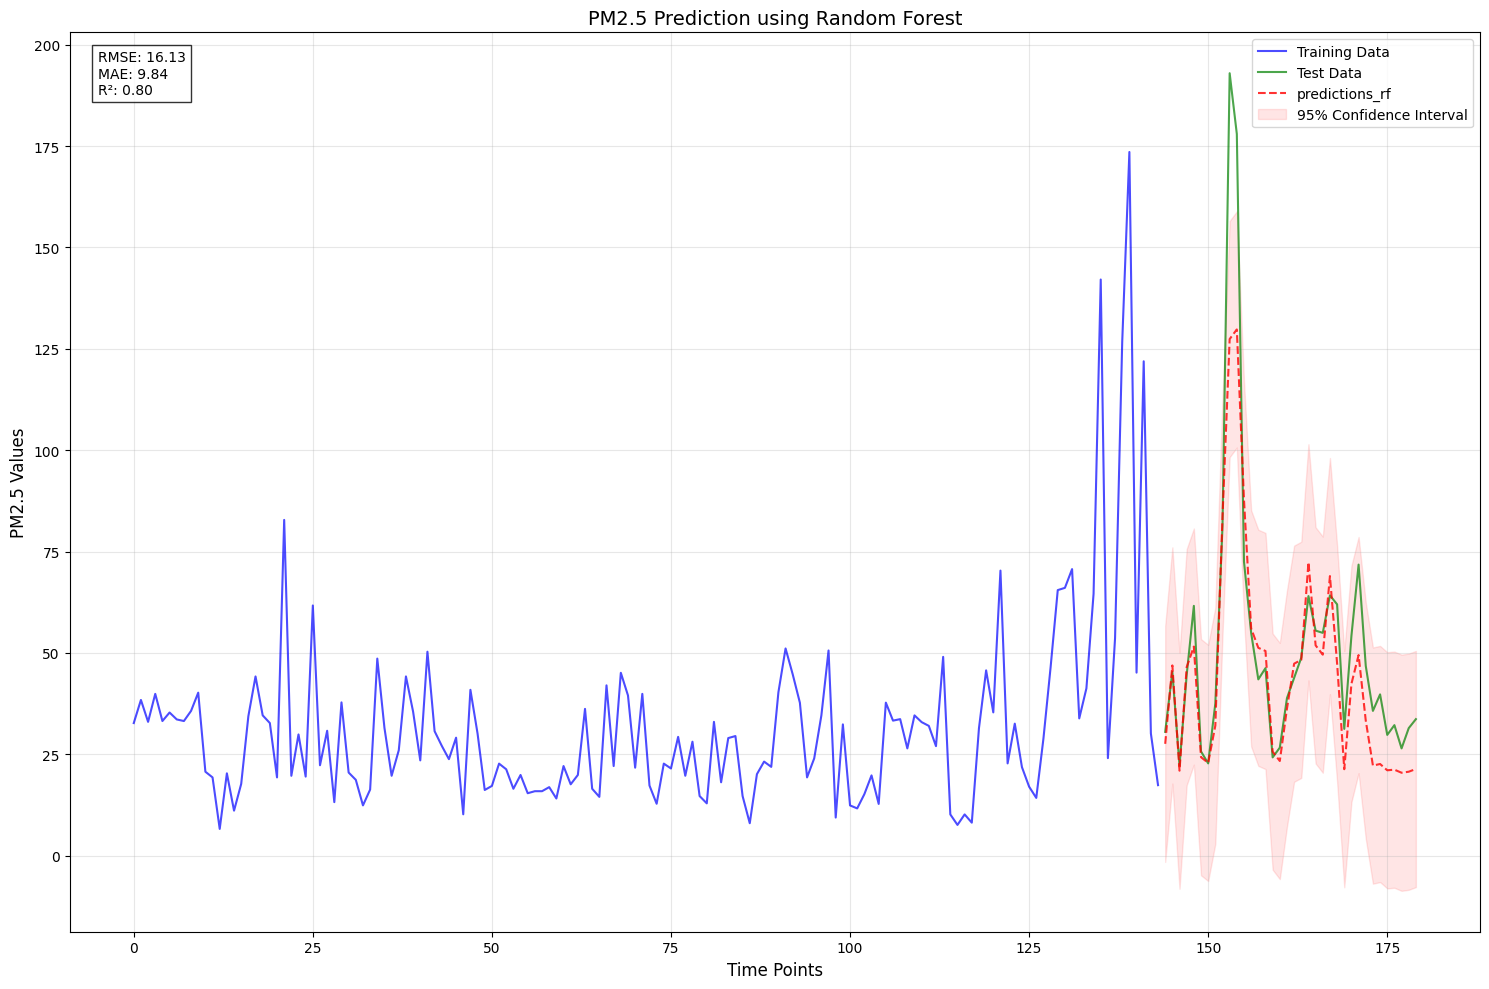

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('../data/processed/filtered_data_thailand_bangkok.csv')

def create_features(df):
    """Create time series features for the Random Forest model"""
    df_features = pd.DataFrame()
    
    # Use all available features
    df_features['PM10'] = df['air_quality_PM10']
    df_features['EPA_index'] = df['air_quality_us-epa-index']
    df_features['CO'] = df['air_quality_Carbon_Monoxide']
    df_features['temperature'] = df['temperature_celsius']
    df_features['humidity'] = df['humidity']
    
    # Create lagged features for PM2.5
    for i in range(1, 4):  # Create 3 lag features
        df_features[f'PM25_lag_{i}'] = df['air_quality_PM2.5'].shift(i)
    
    # Create rolling mean features
    for window in [3, 6, 12]:
        df_features[f'PM25_rolling_mean_{window}'] = df['air_quality_PM2.5'].rolling(window=window).mean()
        df_features[f'PM10_rolling_mean_{window}'] = df['air_quality_PM10'].rolling(window=window).mean()
        df_features[f'CO_rolling_mean_{window}'] = df['air_quality_Carbon_Monoxide'].rolling(window=window).mean()
    
    return df_features

def prepare_data(df, target_col='air_quality_PM2.5'):
    """Prepare data for Random Forest model"""
    # Create features
    features = create_features(df)
    target = df[target_col]
    
    # Remove rows with NaN values (created by lag/rolling features)
    features = features.dropna()
    target = target[features.index]
    
    # Split the data (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, shuffle=False
    )
    
    # Save the training and testing data to separate files
    X_train.to_csv('../data/processed/X_train.csv', index=False)
    X_test.to_csv('../data/processed/X_test.csv', index=False)
    y_train.to_csv('../data/processed/y_train.csv', index=False)
    y_test.to_csv('../data/processed/y_test.csv', index=False)
    
    return X_train, X_test, y_train, y_test

def train_random_forest(X_train, y_train, X_test):
    """Train Random Forest model and make predictions_rf"""
    # Initialize and train the model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    
    # Make predictions_rf
    predictions_rf = rf_model.predict(X_test)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return predictions_rf, feature_importance

def plot_results(y_train, y_test, predictions_rf):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(range(len(y_train)), y_train, 
             label='Training Data', color='blue', alpha=0.7)
    
    # Plot test data and predictions_rf
    test_range = range(len(y_train), len(y_train) + len(y_test))
    plt.plot(test_range, y_test, 
             label='Test Data', color='green', alpha=0.7)
    plt.plot(test_range, predictions_rf, 
             label='predictions_rf', color='red', linestyle='--', alpha=0.8)
    
    # Calculate confidence intervals using prediction std
    residuals = y_test - predictions_rf
    std_dev = np.std(residuals)
    plt.fill_between(test_range,
                     predictions_rf - 2*std_dev,
                     predictions_rf + 2*std_dev,
                     color='red', alpha=0.1,
                     label='95% Confidence Interval')
    
    plt.title('PM2.5 Prediction using Random Forest', fontsize=14)
    plt.xlabel('Time Points', fontsize=12)
    plt.ylabel('PM2.5 Values', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions_rf)):.2f}\n'
    metrics_text += f'MAE: {mean_absolute_error(y_test, predictions_rf):.2f}\n'
    metrics_text += f'R²: {r2_score(y_test, predictions_rf):.2f}'
    
    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance):
    """Plot feature importance"""
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['feature'][:10], 
             feature_importance['importance'][:10])
    plt.title('Top 10 Most Important Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# Prepare the data
print("Preparing data...")
X_train, X_test, y_train, y_test = prepare_data(data)

# Train model and make predictions_rf
print("\nTraining Random Forest model...")
predictions_rf, feature_importance = train_random_forest(X_train, y_train, X_test)

# Calculate metrics
mse_rf = mean_squared_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)

# Print results
print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"Root Mean Squared Error: {rmse_rf:.2f}")
print(f"Mean Absolute Error: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

# Make next day prediction
print("\nNext Day Prediction:")
last_features = X_test.iloc[-1:].copy()
next_day_prediction = pd.DataFrame(predictions_rf).iloc[-1:].values[0][0]
print(f"Predicted PM2.5 value for next day: {next_day_prediction:.2f}")

# Visualize results
print("\nPlotting results...")
plot_results(y_train, y_test, predictions_rf)


### compare performance

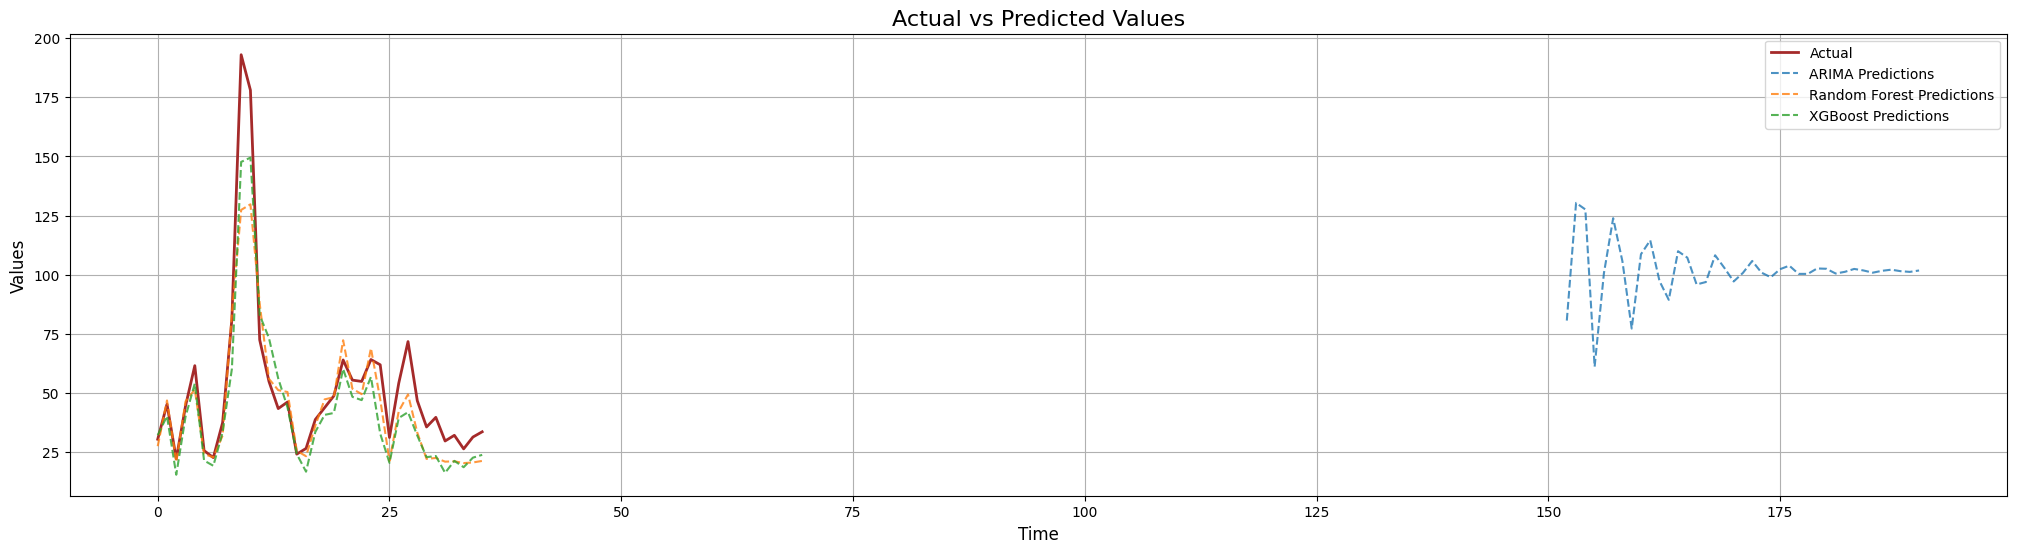

In [4]:


import matplotlib.pyplot as plt

# Ensure the target column from y_test is extracted
y_actual = y_test.values  # Update with actual column name

# Plot the actual values and predictions
plt.figure(figsize=(25, 6))

# Plot actual values
plt.plot(y_actual, label="Actual", color="Brown", linewidth=2)

# Plot predictions
plt.plot(predictions_arima, label="ARIMA Predictions", linestyle="--", alpha=0.8)
plt.plot(predictions_rf, label="Random Forest Predictions", linestyle="--", alpha=0.8)
plt.plot(predictions_xgb, label="XGBoost Predictions", linestyle="--", alpha=0.8)

# Add labels, legend, and title
plt.title("Actual vs Predicted Values", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



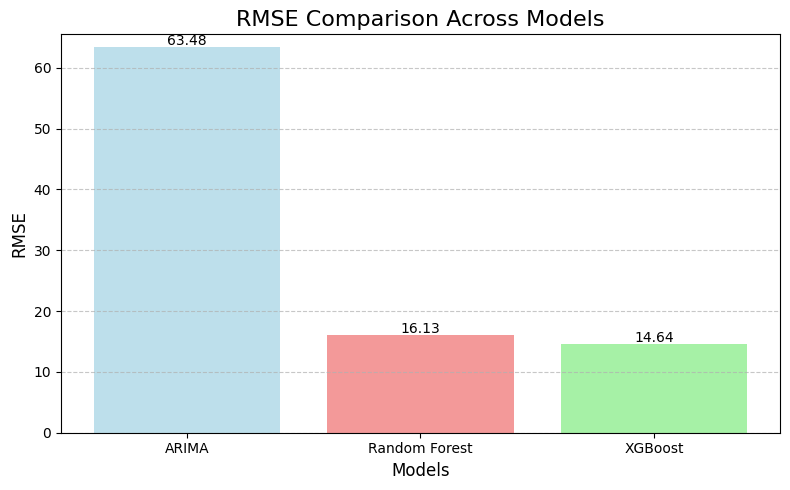

In [5]:
models = ["ARIMA", "Random Forest", "XGBoost"]
rmse_values = [rmse_arima, rmse_rf, rmse_xgb]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, rmse_values, color=['lightblue', 'lightcoral', 'lightgreen'], alpha=0.8)

# Add values above bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{bar.get_height():.2f}', ha='center', fontsize=10)

# Customize the chart
plt.title("RMSE Comparison Across Models", fontsize=16)
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0, max(rmse_values) + 2)  # Set Y-axis limit slightly above the highest RMSE
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()